<a href="https://colab.research.google.com/github/happyhillll/-/blob/main/word2vec%ED%8A%9C%ED%86%A0%EB%A6%AC%EC%96%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [ ]:
df = pd.read_csv('/content/simpsons_dataset.csv')
df.shape

(158314, 2)

In [ ]:
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [ ]:
df.isnull().sum()

raw_character_text    17814
spoken_words          26459
dtype: int64

In [ ]:
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

raw_character_text    0
spoken_words          0
dtype: int64

In [ ]:
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [ ]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])

In [ ]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.07 mins


In [ ]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(85964, 1)

In [ ]:
from gensim.models.phrases import Phrases, Phraser

In [ ]:
sent = [row.split() for row in df_clean['clean']]

In [ ]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

INFO - 06:52:43: collecting all words and their counts
INFO - 06:52:43: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 06:52:43: PROGRESS: at sentence #10000, processed 63561 words and 52816 word types
INFO - 06:52:44: PROGRESS: at sentence #20000, processed 130943 words and 99866 word types
INFO - 06:52:44: PROGRESS: at sentence #30000, processed 192972 words and 138532 word types
INFO - 06:52:44: PROGRESS: at sentence #40000, processed 249842 words and 172659 word types
INFO - 06:52:44: PROGRESS: at sentence #50000, processed 311265 words and 208566 word types
INFO - 06:52:44: PROGRESS: at sentence #60000, processed 373588 words and 243702 word types
INFO - 06:52:44: PROGRESS: at sentence #70000, processed 436441 words and 278740 word types
INFO - 06:52:44: PROGRESS: at sentence #80000, processed 497829 words and 311886 word types
INFO - 06:52:44: collected 330804 word types from a corpus of 537160 words (unigram + bigrams) and 85964 sentences
INFO - 06:52:44: us

In [ ]:
bigram = Phraser(phrases)

INFO - 06:52:44: source_vocab length 330804
INFO - 06:52:48: Phraser built with 126 phrasegrams


In [ ]:
sentences = bigram[sent]

In [ ]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

30178

In [ ]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['oh', 'like', 'know', 'get', 'hey', 'think', 'right', 'look', 'want', 'come']

In [ ]:
import multiprocessing

from gensim.models import Word2Vec

In [ ]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [ ]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [ ]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 06:52:50: collecting all words and their counts
INFO - 06:52:50: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 06:52:50: PROGRESS: at sentence #10000, processed 61718 words, keeping 9558 word types
INFO - 06:52:50: PROGRESS: at sentence #20000, processed 127351 words, keeping 14506 word types
INFO - 06:52:51: PROGRESS: at sentence #30000, processed 187829 words, keeping 17619 word types
INFO - 06:52:51: PROGRESS: at sentence #40000, processed 243332 words, keeping 20385 word types
INFO - 06:52:51: PROGRESS: at sentence #50000, processed 303182 words, keeping 22878 word types
INFO - 06:52:51: PROGRESS: at sentence #60000, processed 363940 words, keeping 25200 word types
INFO - 06:52:52: PROGRESS: at sentence #70000, processed 425408 words, keeping 27401 word types
INFO - 06:52:52: PROGRESS: at sentence #80000, processed 485464 words, keeping 29275 word types
INFO - 06:52:52: collected 30178 word types from a corpus of 523700 raw words and 85964 sentence

Time to build vocab: 0.05 mins


In [ ]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 06:52:53: training model with 1 workers on 3319 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 06:52:54: EPOCH 1 - PROGRESS: at 33.37% examples, 64761 words/s, in_qsize 0, out_qsize 0
INFO - 06:52:55: EPOCH 1 - PROGRESS: at 67.17% examples, 63336 words/s, in_qsize 1, out_qsize 0
INFO - 06:52:56: worker thread finished; awaiting finish of 0 more threads
INFO - 06:52:56: EPOCH - 1 : training on 523700 raw words (198820 effective words) took 3.0s, 65494 effective words/s
INFO - 06:52:57: EPOCH 2 - PROGRESS: at 33.37% examples, 65645 words/s, in_qsize 1, out_qsize 0
INFO - 06:52:58: EPOCH 2 - PROGRESS: at 70.95% examples, 67354 words/s, in_qsize 0, out_qsize 0
INFO - 06:52:59: worker thread finished; awaiting finish of 0 more threads
INFO - 06:52:59: EPOCH - 2 : training on 523700 raw words (199218 effective words) took 2.9s, 68192 effective words/s
INFO - 06:53:00: EPOCH 3 - PROGRESS: at 33.37% examples, 66050 words/s, in_qsize 0, out_qsize 0


Time to train the model: 1.55 mins


In [ ]:
w2v_model.init_sims(replace=True)

INFO - 06:54:26: precomputing L2-norms of word weight vectors


In [ ]:
w2v_model.wv.most_similar(positive=["homer"])

[('bongo', 0.781727135181427),
 ('marge', 0.762418806552887),
 ('wife', 0.7553746700286865),
 ('snuggle', 0.7483620047569275),
 ('rude', 0.7481139898300171),
 ('sorry', 0.746907114982605),
 ('gee', 0.7372888326644897),
 ('crummy', 0.7344343066215515),
 ('sweetheart', 0.7336989641189575),
 ('adopt', 0.7304152846336365)]

In [ ]:
w2v_model.wv.most_similar(positive=["homer_simpson"])

[('recent', 0.7716342806816101),
 ('congratulation', 0.7679205536842346),
 ('easily', 0.7631253004074097),
 ('council', 0.7604875564575195),
 ('waylon', 0.7458096146583557),
 ('committee', 0.7419329881668091),
 ('defeat', 0.7363244891166687),
 ('pleased', 0.7324295043945312),
 ('governor', 0.7311977744102478),
 ('robert', 0.7292210459709167)]

In [ ]:
w2v_model.wv.most_similar(positive=["marge"])

[('convince', 0.7938133478164673),
 ('attract', 0.762791097164154),
 ('homer', 0.762418806552887),
 ('darling', 0.7606180310249329),
 ('sorry', 0.7605972290039062),
 ('ralphie', 0.7547937631607056),
 ('sure', 0.754260778427124),
 ('becky', 0.75421142578125),
 ('grownup', 0.749367356300354),
 ('rude', 0.7458109855651855)]

In [ ]:
w2v_model.wv.most_similar(positive=["bart"])

[('lisa', 0.8451727628707886),
 ('homework', 0.8054009079933167),
 ('upset', 0.7898616194725037),
 ('substitute', 0.7840583920478821),
 ('mom', 0.7834343910217285),
 ('surprised', 0.7804243564605713),
 ('convince', 0.7728426456451416),
 ('hearing', 0.7654814720153809),
 ('strangle', 0.7634938955307007),
 ('mom_dad', 0.7573662400245667)]

In [ ]:
w2v_model.wv.similarity("moe", 'tavern')

0.8841515

In [ ]:
w2v_model.wv.similarity('maggie', 'baby')

0.72445583

In [ ]:
w2v_model.wv.similarity('bart', 'nelson')

0.6681058

In [ ]:
w2v_model.wv.doesnt_match(['jimbo', 'milhouse', 'kearney'])

WARNING - 06:56:10: vectors for words {'kearney'} are not present in the model, ignoring these words
/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'milhouse'

In [ ]:
w2v_model.wv.doesnt_match(["nelson", "bart", "milhouse"])

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'nelson'

In [ ]:
w2v_model.wv.doesnt_match(['homer', 'patty', 'selma'])

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'homer'

In [ ]:
w2v_model.wv.most_similar(positive=["woman", "homer"], negative=["marge"], topn=3)

[('admire', 0.6767112016677856),
 ('obvious', 0.6346961855888367),
 ('drunken', 0.6259676814079285)]

In [ ]:
w2v_model.wv.most_similar(positive=["woman", "bart"], negative=["man"], topn=3)

[('upset', 0.754841685295105),
 ('lisa', 0.751539945602417),
 ('parent', 0.7325302362442017)]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)

    # gets list of most similar words
    close_words = model.wv.most_similar([word])

    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=10).fit_transform(arrays)

    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)

    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})

    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)

    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                  }
                     )

    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
        p1.text(df["x"][line],
                df['y'][line],
                '  ' + df["words"][line].title(),
                horizontalalignment='left',
                verticalalignment='bottom', size='medium',
                color=df['color'][line],
                weight='normal'
                ).set_size(15)

    plt.xlim(Y[:, 0].min() - 50, Y[:, 0].max() + 50)
    plt.ylim(Y[:, 1].min() - 50, Y[:, 1].max() + 50)

    plt.title('t-SNE visualization for {}'.format(word.title()))
    plt.show()

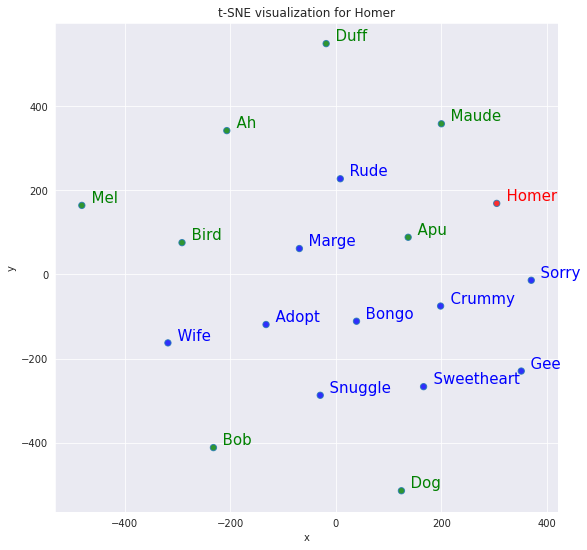

In [ ]:
tsnescatterplot(w2v_model, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])

In [ ]:
tsnescatterplot(w2v_model, 'maggie', [i[0] for i in w2v_model.wv.most_similar(negative=["maggie"])])

ValueError: ignored

In [ ]:
tsnescatterplot(w2v_model, "mr_burn", [t[0] for t in w2v_model.wv.most_similar(positive=["mr_burn"], topn=20)][10:])

KeyError: ignored